### Univariate Forecasting for Multi step and Parallel input LSTM
we can do:
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- univariate: These are problems comprised of a single series of observations and a model is required to learn from the series of past observations to predict the next value in the sequence.
- multivariate
- multi-step

In [606]:
import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
#matplotlib.rcParams['axes.labelsize'] = 14
#matplotlib.rcParams['xtick.labelsize'] = 12
#matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'

from array import array
import numpy as np
from numpy import hstack

In [3]:
df = pd.read_csv('preprocessed.csv')
#df = df.rename(columns={'Project_Number': 'Project Number', 'Project_Name' : 'Project Name'})
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['Project Number'] = df['Project Number'].astype('str') 
df['Fiscal Period Code'] = pd.to_datetime(df['Fiscal Period Code'], format='%Y%m') 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

### fill all nan values with zero

In [775]:
df['Actual Net Revenue - MTD'].fillna(0, inplace=True)

## let's only select projects that are unique per timestep

In [776]:
## Imported from the previous analysis

#change the df to the larger one so to obtain also other projects
def random_project(df):
    df = df.sample(n=1)
    project_number = df['Project Number'].item()
    return project_number

#larger dataframe including shifted backlog
def obtain_df(project):
    df_project = df[df['Project Number'] == project]
    #df_project = df_project[['Fiscal Period Code', 'Funding Amount - ITC (Snapshot)', 'Backlog NR', 'Actual Gross Revenue - MTD']].copy()
    df_project['Backlog_Shifted'] = df_project['Backlog NR'].transform(lambda x:x.shift())
    df_project.reset_index(inplace=True)
    df_project = df_project.loc[:, ~df_project.columns.str.contains('^index')]
    return df_project

#is called in the next function
def decomposition_plot(project_number, name, sector):
    df_pn= df[df['Project Number'] == project_number]
    df_pn = df_pn[['Fiscal Period Code', 'Actual Net Revenue - MTD']].copy()
    df_pn = df_pn.set_index('Fiscal Period Code')
    decomposition = sm.tsa.seasonal_decompose(df_pn, model='additive')
    fig = decomposition.plot()
    return print(f" Selected Project Number: {project_number}"), print(f" Name: {name}"), print(f" Sector: {sector}"), plt.show()

#selected analysis
def selected_project_analysis(project):
    df_x = df[df['Project Number'] == project]
    name = df_x['Project Name'].iloc[-1]
    sector = df_x['Ultimate Customer AUS Market Sector'].iloc[-1]
    return decomposition_plot(project, name, sector)

#obtain only the time series function, required obtain_df
def obtain_timeseries(project):
    df_pn = obtain_df(project)
    df_pn = df_pn[['Fiscal Period Code', 'Actual Net Revenue - MTD']].copy()
    df_pn = df_pn.set_index('Fiscal Period Code')
    return df_pn

#revenue analysis can be called on all projects regardless of length
def revenue_analysis(project):
    df_project = df[df['Project Number'] == project]
    df_project = df_project[['Fiscal Period Code', 'Funding Amount - ITC (Snapshot)', 'Backlog NR', 'Actual Net Revenue - MTD']].copy()
    df_project['Backlog_Shifted'] = df_project['Backlog NR'].transform(lambda x:x.shift())
    df_project.reset_index(inplace=True)
    df_project = df_project.loc[:, ~df_project.columns.str.contains('^index')]
    subset= df_project[['Fiscal Period Code', 'Actual Net Revenue - MTD']].copy()
    subset.plot(y ='Actual Net Revenue - MTD', x="Fiscal Period Code", kind="line")
    return pyplot.show()

In [939]:
x = random_project(df)
x

'30014840'

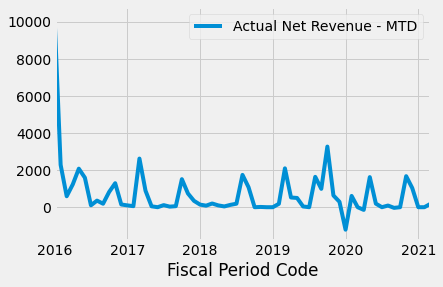

In [324]:
revenue_analysis(x)

 Selected Project Number: 30001798
 Name: 01368047.0000-Orkin Clearwater SI
 Sector: Chemicals


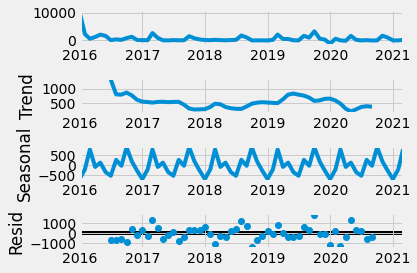

(None, None, None, None)

In [325]:
selected_project_analysis(x)

### For univariate forecasting, we need to prepare the data into chuncks

In [327]:
def obtain_sequence(project):
    df_t = obtain_timeseries(project)
    sequence = df_t['Actual Net Revenue - MTD'].values
    sequence = sequence.tolist()
    return sequence

In [328]:
len(obtain_sequence(x))%3

0

In [450]:
def call_sequence(x, n_steps):
    if len(obtain_sequence(x))%3 == 0:
        sequence = obtain_sequence(x)
        n_steps = n_steps
        return sequence, n_steps

In [349]:
# split a univariate sequence into samples

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return  np.array(X), np.array(y)

In [331]:
sequence, n_steps = call_sequence(x, 6) 

X, y = split_sequence(sequence, n_steps)
    # summarize the data
for i in range(len(X)):
    print(X[i], y[i])

[10223.97  2284.     591.27  1229.68  2077.75  1591.95] 102.5
[2284.    591.27 1229.68 2077.75 1591.95  102.5 ] 355.5
[ 591.27 1229.68 2077.75 1591.95  102.5   355.5 ] 188.5
[1229.68 2077.75 1591.95  102.5   355.5   188.5 ] 822.03
[2077.75 1591.95  102.5   355.5   188.5   822.03] 1293.94
[1591.95  102.5   355.5   188.5   822.03 1293.94] 147.0
[ 102.5   355.5   188.5   822.03 1293.94  147.  ] 98.5
[ 355.5   188.5   822.03 1293.94  147.     98.5 ] 56.0
[ 188.5   822.03 1293.94  147.     98.5    56.  ] 2621.95
[ 822.03 1293.94  147.     98.5    56.   2621.95] 891.16
[1293.94  147.     98.5    56.   2621.95  891.16] 49.0
[ 147.     98.5    56.   2621.95  891.16   49.  ] 0.0
[  98.5    56.   2621.95  891.16   49.      0.  ] 112.0
[  56.   2621.95  891.16   49.      0.    112.  ] 30.6
[2621.95  891.16   49.      0.    112.     30.6 ] 56.0
[891.16  49.     0.   112.    30.6   56.  ] 1512.49
[  49.      0.    112.     30.6    56.   1512.49] 741.25
[   0.    112.     30.6    56.   1512.49  741.

In [332]:
X.shape, y.shape

((57, 6), (57,))

## We produce one train and one test set here

In [333]:
x_input = X[len(X) - 1]
X = X[0:-1]
#xx = np.delete(X, index_x)

y_test = y[len(y) - 1]
y = y[0:-1]

In [334]:
X.shape[0], X.shape[1]

(56, 6)

In [498]:
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.layers import Activation, Dense
from keras.optimizers import Adam


In [336]:
#  [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
x_input = x_input.reshape((1, n_steps, n_features))

### Vaniall LSTM

In [337]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [338]:
model.fit(X, y, epochs=200, verbose=0)

In [339]:
yhat = model.predict(x_input, verbose=0)
print(yhat, y_test)

[[103.17646]] 180.0


### Stacked LSTM

In [340]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [341]:
model.fit(X, y, epochs=200, verbose=0)
yhat = model.predict(x_input, verbose=0)
print(yhat, y_test)

[[337.91037]] 180.0


### Bidirectional LSTM
We can implement a Bidirectional LSTM for univariate time series forecasting by wrapping the first hidden layer in a wrapper layer called Bidirectional.
An example of defining a Bidirectional LSTM to read input both forward and backward is as follows.

In [342]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [343]:
model.fit(X, y, epochs=200, verbose=0)
yhat = model.predict(x_input, verbose=0)
print(yhat, y_test)

[[176.22055]] 180.0


### CNN LSTM
the input here is a bit different	
[samples, subsequences, timesteps, features]

This can be achieved by wrapping the entire CNN model in a TimeDistributed wrapper that will apply the entire model once per input, in this case, once per input subsequence.

The CNN model first has a convolutional layer for reading across the subsequence that requires a number of filters and a kernel size to be specified. The number of filters is the number of reads or interpretations of the input sequence. The kernel size is the number of time steps included of each ‘read’ operation of the input sequence.

The convolution layer is followed by a max pooling layer that distills the filter maps down to 1/2 of their size that includes the most salient features. These structures are then flattened down to a single one-dimensional vector to be used as a single input time step to the LSTM layer.

In [573]:
#call the sequence 
sequence, n_steps = call_sequence(x, 4) #we can play around with different input sizes (e.g. 4, 6, 12, 18), with larger lookback windows the resulst seem to have more variance?

#Split the sequence again
X, y = split_sequence(sequence, n_steps)

#we split up the last values to and save them as the test input
x_input = X[len(X) - 1]
X = X[0:-1]
y_test = y[len(y) - 1]
y = y[0:-1]

#reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
steps = int(n_steps/n_seq)

X = X.reshape((X.shape[0], n_seq, steps, n_features))
x_input = x_input.reshape((1, n_seq, steps, n_features))

In [574]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [575]:
print(model.summary())

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_116 (TimeDi (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_117 (TimeDi (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_118 (TimeDi (None, None, 64)          0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 51        
Total params: 23,179
Trainable params: 23,179
Non-trainable params: 0
_________________________________________________________________
None


In [576]:
model.fit(X, y, epochs=500, verbose=0)

In [577]:
yhat = model.predict(x_input, verbose=0)
print(yhat, y_test)

[[227.46594]] 180.0


In [565]:
x_input

array([[[[1674. ],
         [1035.4]],

        [[   0. ],
         [   0. ]]]])

### ConvLSTM

A type of LSTM related to the CNN-LSTM is the ConvLSTM, where the convolutional reading of input is built directly into each LSTM unit.

The ConvLSTM was developed for reading two-dimensional spatial-temporal data, but can be adapted for use with univariate time series forecasting.

[samples, timesteps, rows, columns, features]

In [600]:
#call the sequence 
sequence, n_steps = call_sequence(x, 4) #we can play around with different input sizes, it looks like larger look-back windows work better (e.g. 9, 12, 18)

#Split the sequence again
X, y = split_sequence(sequence, n_steps)

#we split up the last values to and save them as the test input
x_input = X[len(X) - 1]
X = X[0:-1]
y_test = y[len(y) - 1]
y = y[0:-1]

#reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
steps = int(n_steps/n_seq)

X = X.reshape((X.shape[0], n_seq, 1, steps, n_features))
x_input = x_input.reshape((1, n_seq, 1, steps, n_features))

In [601]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_10 (ConvLSTM2D) (None, 1, 1, 64)          33536     
_________________________________________________________________
flatten_48 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
None


In [602]:
# fit model
model.fit(X, y, epochs=500, verbose=0)

In [603]:
yhat = model.predict(x_input, verbose=0)
print(yhat, y_test)

[[96.96177]] 180.0


## Multiple parallel series
Let's try to forecast a few projects with the same length at the same time. In practice, we could us this to forecast projects from the same category for example. But the input length has to be fixed

In [777]:
def several_random_projects(duration, samplesize):
    subdf = df[df['Projectduration'] == duration]
    subdf = subdf.sample(n= samplesize)
    project_number = subdf['Project Number'].tolist()
    return project_number

In [823]:
def datablock(duration, samplesize, n_steps):
    projectlist = several_random_projects(duration, samplesize) #select random projects of the same lengths
    sequences_list = []
    for item in projectlist:
        sequence = np.array(obtain_sequence(item)) #obtain the time series sequence for each project
        sequence = np.array(sequence)
        sequences_list.append(sequence) #join all sequences in a list
           
    sequences = np.column_stack(sequences_list) #create a matrix
    summed = np.sum(sequences, axis=1)          #sum over timesteps in matrix
    sequences_list.append(summed)               #append the summed column to the list of sequence arrays
    sequences = np.column_stack(sequences_list) #obatin matrixs of sequences
    return sequences, n_steps

In [929]:
# we select projects 200 with a duration of 15, and split the inputs into intervals of 5
sequence, n_steps = datablock(duration=15, samplesize=200, n_steps=6)

In [930]:
sequence

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  2.05578000e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.44000000e+01,  0.00000000e+00,  5.60899330e+05],
       [ 0.00000000e+00,  0.00000000e+00,  1.80674000e+03, ...,
         7.67080000e+02,  0.00000000e+00,  2.74829850e+05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  7.39710000e+02, ...,
         3.29757000e+03,  0.00000000e+00,  3.56849160e+05],
       [ 0.00000000e+00,  0.00000000e+00,  3.63032000e+03, ...,
         0.00000000e+00,  0.00000000e+00, -2.58791902e+06],
       [ 0.00000000e+00,  0.00000000e+00,  2.19235000e+03, ...,
         0.00000000e+00,  0.00000000e+00,  3.25694340e+05]])

In [931]:
X, y = split_sequence(sequence, n_steps)
X.shape

(9, 6, 201)

In [932]:
#we split up the last values to and save them as the test input
x_input = X[len(X) - 1]
X = X[0:-1]
y_test = y[len(y) - 1]
y = y[0:-1]

#reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = X.shape[2]
n_seq = 2
steps = int(n_steps/n_seq)


x_input = x_input.reshape((1, n_steps, n_features))

In [933]:
X.shape, y.shape

((8, 6, 201), (8, 201))

In [934]:
model = Sequential()
model.add(LSTM(100, activation='sigmoid', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='sigmoid'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 6, 100)            120800    
_________________________________________________________________
lstm_87 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_79 (Dense)             (None, 201)               20301     
Total params: 221,501
Trainable params: 221,501
Non-trainable params: 0
_________________________________________________________________
None


In [935]:
model.fit(X, y, epochs=500, verbose=0)

In [936]:
yhat = model.predict(x_input, verbose=0)
print(yhat, y_test)

[[-2.50858259e+00  4.98794746e+01  4.98648338e+01  2.64676323e+01
   5.00134354e+01  4.70223274e+01  5.18532753e+01  4.49701424e+01
   5.03310432e+01  1.68082294e+01 -4.74903603e+01 -2.41288915e-04
  -1.41695794e-03  4.89672203e+01  4.67189026e+01  4.68906670e+01
   4.67690353e+01  5.08980865e+01  5.08438950e+01 -5.19854774e+01
  -2.41098553e-03 -1.27677364e+01  4.22616768e+01  5.09067039e+01
  -5.92758879e-04 -8.11018467e-01  5.01155396e+01  1.96533371e-03
  -9.19555663e-04  4.91268005e+01  2.11273157e-03  2.00904770e+01
   1.48797338e-03  5.10944176e+01 -1.69587135e-03  5.04710312e+01
   1.90199632e-03 -2.56869756e-03  5.11126709e+01 -2.53524631e-05
   1.86194759e-03 -5.92851546e-04  2.03769422e+00  5.17430954e+01
   4.95441246e+01 -6.10700925e-04 -5.15596941e-04  4.87117653e+01
   5.03816795e+01  1.02643389e-04  4.96435013e+01  4.88808060e+01
   5.08300743e+01 -6.58483128e-04  4.70534363e+01  1.44707388e-03
   4.93830338e+01  4.49508362e+01  2.22134914e+01 -2.30036676e-05
   4.96820

In [1]:
mse = ((y_test - y_hat) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

NameError: name 'y_test' is not defined

### Multi-step forecast
###  Vector output and Encoder Decoder LSTM
reshape from [samples, timesteps] into [samples, timesteps, features]